# Project Part1: Employing Deep Learning And Transfer Learning For Accurate Brain Tumor Detection

### Afza Anjum (21I-1724)
### Sharjeel Nadir (21I-2699)
### Areeba Amjad (21I-1777)
### DS-D

### Importing Libraries

In [1]:
# Install required packages
!pip install tensorflow scikit-learn matplotlib seaborn pandas numpy kagglehub

import kagglehub
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet152, VGG19, DenseNet169, MobileNetV3Large

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import KFold
import os
import time

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

### Downloading and Checking the dataset structure

In [2]:
# Download dataset using kagglehub
print("Downloading dataset...")
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")
print("Path to dataset files:", path)

# Check the dataset structure
print("\nDataset contents:")
for root, dirs, files in os.walk(path):
    level = root.replace(path, '').count(os.sep)
    indent = ' ' * 2 * level
    print(f'{indent}{os.path.basename(root)}/')
    subindent = ' ' * 2 * (level + 1)
    for file in files[:5]:  # Show first 5 files
        print(f'{subindent}{file}')
    if len(files) > 5:
        print(f'{subindent}... and {len(files) - 5} more files')

Using Colab cache for faster access to the 'brain-tumor-mri-dataset' dataset.
Path to dataset files: /kaggle/input/brain-tumor-mri-dataset

Dataset contents:
brain-tumor-mri-dataset/
  Training/
    pituitary/
      Tr-pi_0532.jpg
      Tr-pi_0282.jpg
      Tr-pi_1401.jpg
      Tr-pi_0914.jpg
      Tr-pi_0691.jpg
      ... and 1452 more files
    notumor/
      Tr-no_0482.jpg
      Tr-no_0641.jpg
      Tr-no_0592.jpg
      Tr-no_0711.jpg
      Tr-no_0746.jpg
      ... and 1590 more files
    meningioma/
      Tr-me_0529.jpg
      Tr-me_1256.jpg
      Tr-me_0852.jpg
      Tr-me_0494.jpg
      Tr-me_1293.jpg
      ... and 1334 more files
    glioma/
      Tr-gl_0954.jpg
      Tr-gl_0959.jpg
      Tr-gl_1033.jpg
      Tr-gl_1096.jpg
      Tr-gl_1290.jpg
      ... and 1316 more files
  Testing/
    pituitary/
      Te-pi_0059.jpg
      Te-pi_0024.jpg
      Te-pi_0232.jpg
      Te-pi_0286.jpg
      Te-pi_0233.jpg
      ... and 295 more files
    notumor/
      Te-no_0016.jpg
      Te-no_029

### Data preparation and visualization

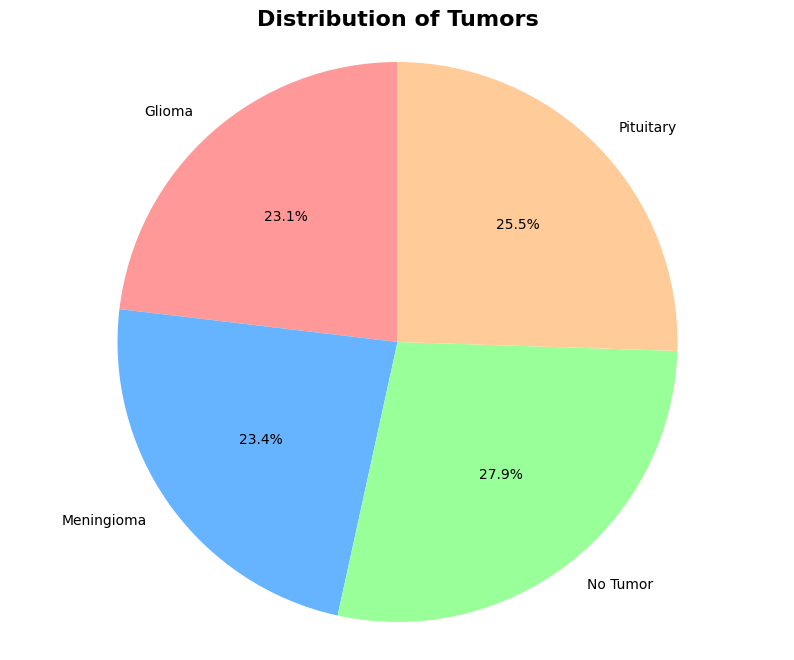

Class Distribution:
glioma: 1321 images
meningioma: 1339 images
notumor: 1595 images
pituitary: 1457 images


In [ ]:

class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']
class_labels = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']

# Count images in each class
class_counts = {}
for class_name in class_names:
    class_path = os.path.join(path, 'Training', class_name)
    class_counts[class_name] = len(os.listdir(class_path))

# Create pie chart as in the paper
plt.figure(figsize=(10, 8))
colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']
plt.pie(class_counts.values(), labels=class_labels, autopct='%1.1f%%',
        colors=colors, startangle=90)
plt.title('Distribution of Tumors', fontsize=16, fontweight='bold')
plt.axis('equal')
plt.show()

# Display class counts
print("Class Distribution:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count} images")

### Data preprocessing and augmentation setup

In [ ]:

IMG_SIZE = (224, 224)
BATCH_SIZE = 128

# Create data generators with augmentation as described in the paper
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # 80-20 split as mentioned in paper
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators
train_generator = train_datagen.flow_from_directory(
    os.path.join(path, 'Training'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    os.path.join(path, 'Training'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    os.path.join(path, 'Testing'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {val_generator.samples}")
print(f"Testing samples: {test_generator.samples}")

Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
Training samples: 4571
Validation samples: 1141
Testing samples: 1311


### Display sample images - normal and augmented

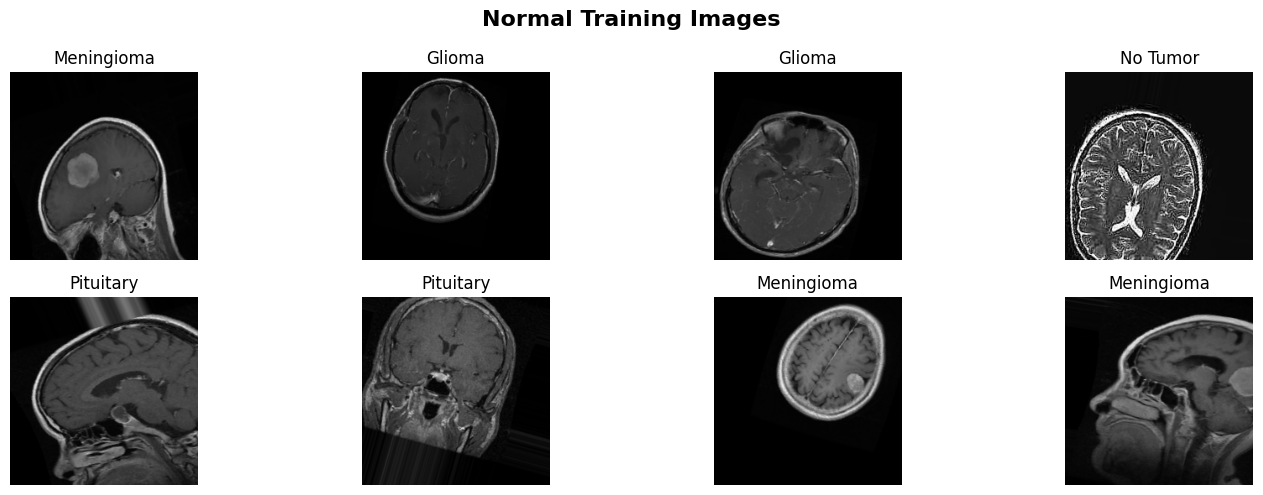

Found 5712 images belonging to 4 classes.


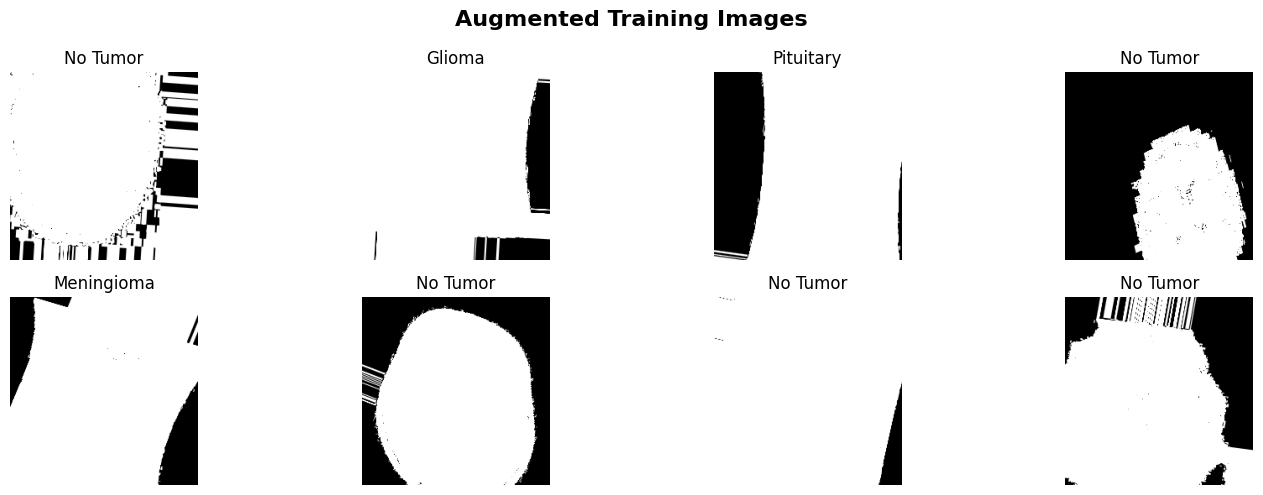

In [ ]:

def display_sample_images(generator, title):
    plt.figure(figsize=(15, 5))
    images, labels = next(generator)

    for i in range(8):
        plt.subplot(2, 4, i+1)
        plt.imshow(images[i])
        class_idx = np.argmax(labels[i])
        plt.title(f'{class_labels[class_idx]}')
        plt.axis('off')

    plt.suptitle(title, fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Display normal images
display_sample_images(train_generator, 'Normal Training Images')

# Create a separate generator for augmented visualization
augmented_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

augmented_generator = augmented_datagen.flow_from_directory(
    os.path.join(path, 'Training'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

display_sample_images(augmented_generator, 'Augmented Training Images')

### Model creation functions

In [ ]:
# Training configuration
EPOCHS = 50
LEARNING_RATE = 0.001

# Model creation functions (need to be defined first)
def create_resnet152_model():
    base_model = ResNet152(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )
    base_model.trainable = False
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(4, activation='softmax')
    ])
    return model

def create_vgg19_model():
    base_model = VGG19(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )
    base_model.trainable = False
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(4, activation='softmax')
    ])
    return model

def create_densenet169_model():
    base_model = DenseNet169(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )
    base_model.trainable = False
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(4, activation='softmax')
    ])
    return model

def create_mobilenetv3_model():
    base_model = MobileNetV3Large(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )
    base_model.trainable = False
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(4, activation='softmax')
    ])
    return model



### Compile model function and Callbacks function

In [7]:
# Compile model function
def compile_model(model):
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Callbacks function
def create_callbacks(model_name):
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=5,
            min_lr=1e-7
        )
    ]
    return callbacks

### Training function with metrics tracking 

In [ ]:


# Initialize dictionaries to store results
models_dict = {}
histories = {}
training_times = {}
results = {}

# Training function with metrics tracking 
def train_model(model, model_name, train_gen, val_gen, epochs=EPOCHS):
    print(f"\n{'='*50}")
    print(f"Training {model_name}")
    print(f"{'='*50}")  

    history = model.fit(
        train_gen,
        epochs=epochs,
        validation_data=val_gen,
        callbacks=create_callbacks(model_name),
        verbose=1
    )

    return history



### Creating training functions for each model

#### ResNet152

In [ ]:

def train_resnet152():
    print("Initializing ResNet152...")
    model = create_resnet152_model()
    model = compile_model(model)

    start_time = time.time()
    history = train_model(model, 'ResNet152', train_generator, val_generator)
    training_time = time.time() - start_time

    # Save model and history
    model.save('ResNet152_brain_tumor_model.h5')
    histories['ResNet152'] = history
    training_times['ResNet152'] = training_time
    models_dict['ResNet152'] = model

    return model, history, training_time

In [10]:

train_resnet152()

Initializing ResNet152...
234698864/234698864 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

Training ResNet152


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 176s 4s/step - accuracy: 0.3579 - loss: 1.4350 - val_accuracy: 0.4286 - val_loss: 1.2688 - learning_rate: 0.0010
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 0.4734 - loss: 1.1191 - val_accuracy: 0.4566 - val_loss: 1.2223 - learning_rate: 0.0010
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.4815 - loss: 1.0873 - val_accuracy: 0.4566 - val_loss: 1.1862 - learning_rate: 0.0010
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.5004 - loss: 1.0615 - val_accuracy: 0.4312 - val_loss: 1.2073 - learning_rate: 0.0010
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 0.5293 - loss: 1.0550 - val_accuracy: 0.5057 - val_loss: 1.1618 - learning_rate: 0.0010
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 0.5155 - loss: 1.0381 - val_accuracy: 0.4610 - val_loss: 1.1654 - learning_rate: 0.0010
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.5356 - loss: 1.0062 - val_accuracy:

(<Sequential name=sequential, built=True>,
 2702.227823972702)

#### VGG19

In [11]:
def train_vgg19():
    print("Initializing VGG19...")
    model = create_vgg19_model()
    model = compile_model(model)

    start_time = time.time()
    history = train_model(model, 'VGG19', train_generator, val_generator)
    training_time = time.time() - start_time

    # Save model and history
    model.save('VGG19_brain_tumor_model.h5')
    histories['VGG19'] = history
    training_times['VGG19'] = training_time
    models_dict['VGG19'] = model

    return model, history, training_time

In [12]:
train_vgg19()

Initializing VGG19...
80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

Training VGG19
Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 200s 4s/step - accuracy: 0.3663 - loss: 1.3709 - val_accuracy: 0.5749 - val_loss: 1.0774 - learning_rate: 0.0010
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.6249 - loss: 0.9132 - val_accuracy: 0.6266 - val_loss: 1.0024 - learning_rate: 0.0010
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.7118 - loss: 0.7519 - val_accuracy: 0.6249 - val_loss: 0.9431 - learning_rate: 0.0010
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.7225 - loss: 0.6775 - val_accuracy: 0.6494 - val_loss: 0.9069 - learning_rate: 0.0010
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.7530 - loss: 0.6316 - val_accuracy: 0.6494 - val_loss: 0.8599 - learning_rate: 0.0010
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 0.7705 - loss: 0.5890 - val_accuracy: 0.6713 - val_loss: 0.8277 - learning_rate: 0.0010
Epoch 7/50

(<Sequential name=sequential_1, built=True>,
 3557.707870721817)

#### DenseNet169

In [13]:
def train_densenet169():
    print("Initializing DenseNet169...")
    model = create_densenet169_model()
    model = compile_model(model)

    start_time = time.time()
    history = train_model(model, 'DenseNet169', train_generator, val_generator)
    training_time = time.time() - start_time

    # Save model and history
    model.save('DenseNet169_brain_tumor_model.h5')
    histories['DenseNet169'] = history
    training_times['DenseNet169'] = training_time
    models_dict['DenseNet169'] = model

    return model, history, training_time

In [14]:
train_densenet169()

Initializing DenseNet169...
51877672/51877672 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

Training DenseNet169
Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 208s 4s/step - accuracy: 0.6065 - loss: 0.9358 - val_accuracy: 0.7546 - val_loss: 0.6957 - learning_rate: 0.0010
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.8753 - loss: 0.3658 - val_accuracy: 0.7344 - val_loss: 0.6759 - learning_rate: 0.0010
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - accuracy: 0.8818 - loss: 0.3295 - val_accuracy: 0.7940 - val_loss: 0.5536 - learning_rate: 0.0010
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.8960 - loss: 0.2922 - val_accuracy: 0.7923 - val_loss: 0.5272 - learning_rate: 0.0010
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.8863 - loss: 0.3028 - val_accuracy: 0.8019 - val_loss: 0.5418 - learning_rate: 0.0010
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.9091 - loss: 0.2526 - val_accuracy: 0.8195 - val_loss: 0.4872 - learning_rate: 0.001

(<Sequential name=sequential_2, built=True>,
 4090.2531609535217)

#### MobileNetV3

In [15]:
def train_mobilenetv3():
    print("Initializing MobileNetV3...")
    model = create_mobilenetv3_model()
    model = compile_model(model)

    start_time = time.time()
    history = train_model(model, 'MobileNetV3', train_generator, val_generator)
    training_time = time.time() - start_time

    # Save model and history
    model.save('MobileNetV3_brain_tumor_model.h5')
    histories['MobileNetV3'] = history
    training_times['MobileNetV3'] = training_time
    models_dict['MobileNetV3'] = model

    return model, history, training_time

In [16]:
train_mobilenetv3()

Initializing MobileNetV3...
12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

Training MobileNetV3
Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 128s 3s/step - accuracy: 0.3507 - loss: 1.3277 - val_accuracy: 0.4400 - val_loss: 1.2660 - learning_rate: 0.0010
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.4532 - loss: 1.1776 - val_accuracy: 0.4145 - val_loss: 1.2235 - learning_rate: 0.0010
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - accuracy: 0.4891 - loss: 1.1265 - val_accuracy: 0.4917 - val_loss: 1.1857 - learning_rate: 0.0010
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.5243 - loss: 1.0719 - val_accuracy: 0.5145 - val_loss: 1.1588 - learning_rate: 0.0010
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.5235 - loss: 1.0512 - val_accuracy: 0.5250 - val_loss: 1.1432 - learning_rate: 0.0010
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.5759 - loss: 1.0031 - val_accuracy: 0.5153 - val_loss: 1.1353 - learning_rate: 0.001

(<Sequential name=sequential_3, built=True>,
 3765.6979320049286)

### Plot training history

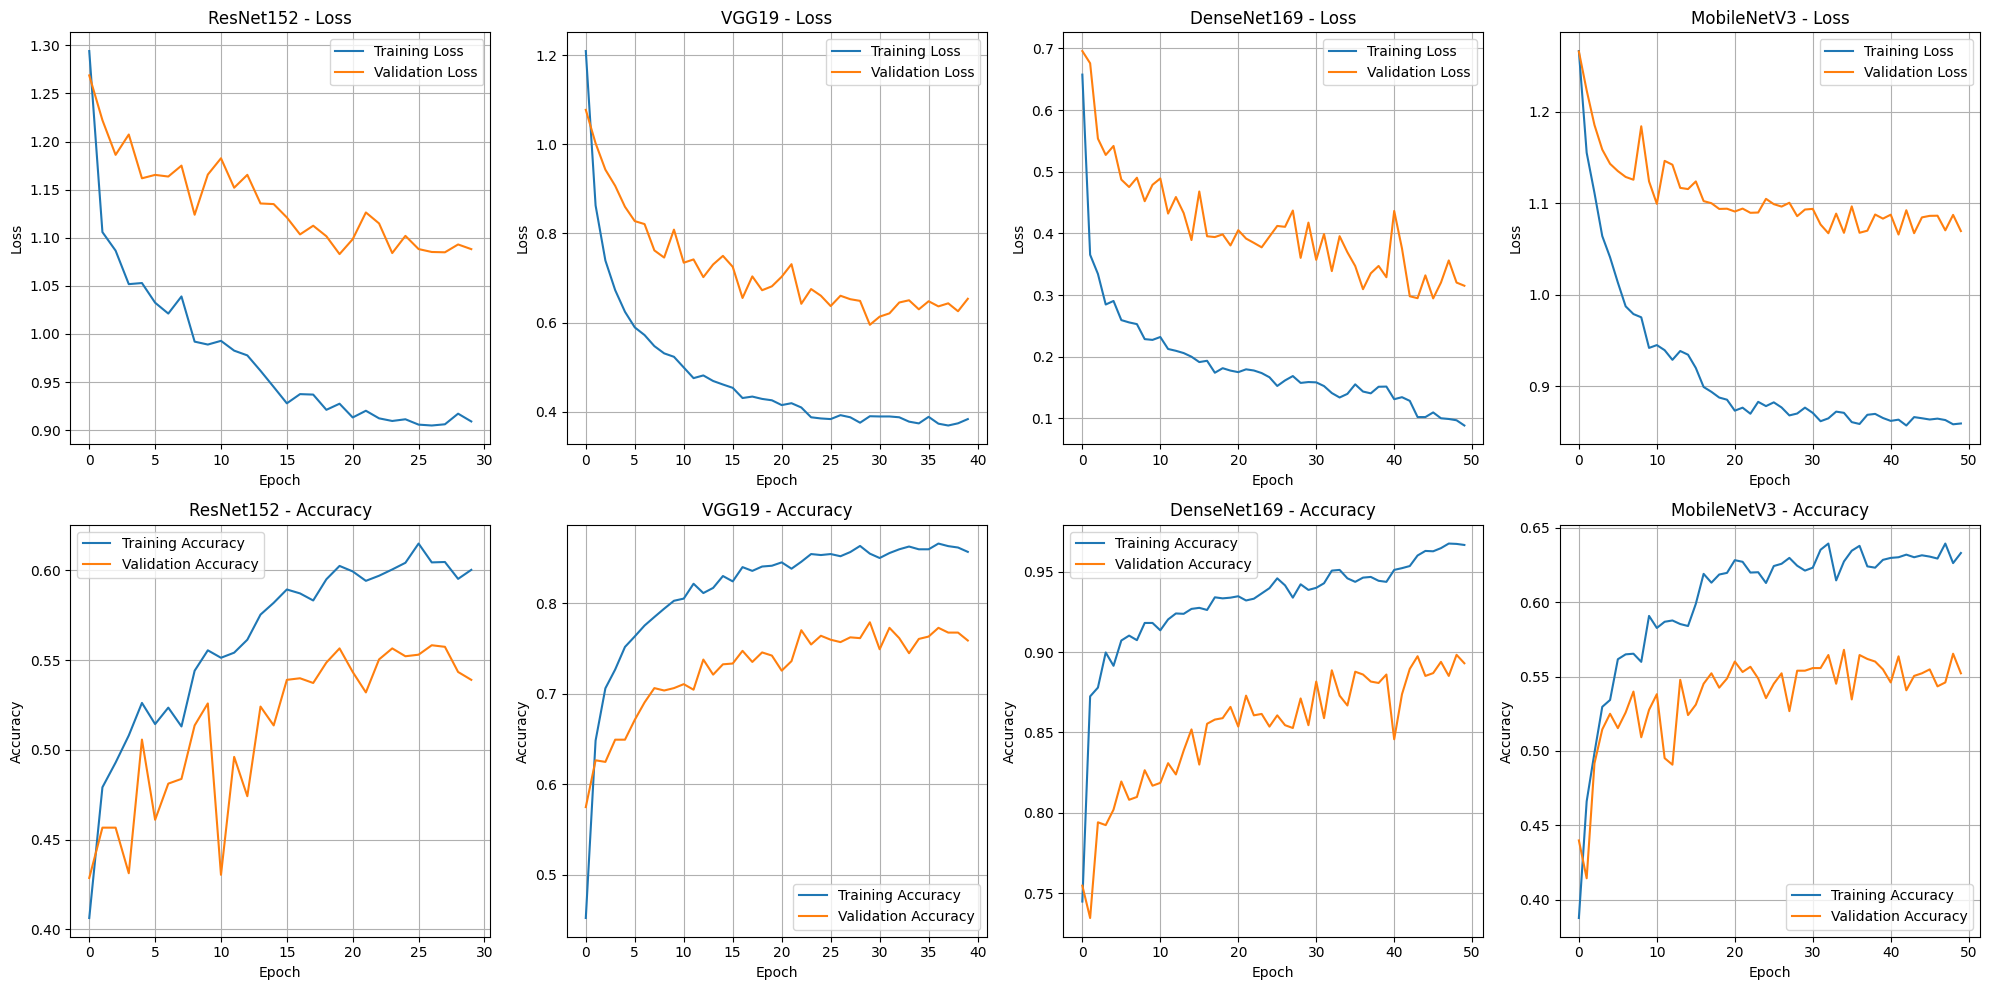

In [ ]:

def plot_training_history(histories):
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    models = list(histories.keys())

    for i, model_name in enumerate(models):
        history = histories[model_name]

        # Plot loss
        axes[0, i].plot(history.history['loss'], label='Training Loss')
        axes[0, i].plot(history.history['val_loss'], label='Validation Loss')
        axes[0, i].set_title(f'{model_name} - Loss')
        axes[0, i].set_xlabel('Epoch')
        axes[0, i].set_ylabel('Loss')
        axes[0, i].legend()
        axes[0, i].grid(True)

        # Plot accuracy
        axes[1, i].plot(history.history['accuracy'], label='Training Accuracy')
        axes[1, i].plot(history.history['val_accuracy'], label='Validation Accuracy')
        axes[1, i].set_title(f'{model_name} - Accuracy')
        axes[1, i].set_xlabel('Epoch')
        axes[1, i].set_ylabel('Accuracy')
        axes[1, i].legend()
        axes[1, i].grid(True)

    plt.tight_layout()
    plt.show()

plot_training_history(histories)

### Model evaluation and metrics


Evaluating ResNet152
11/11 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step


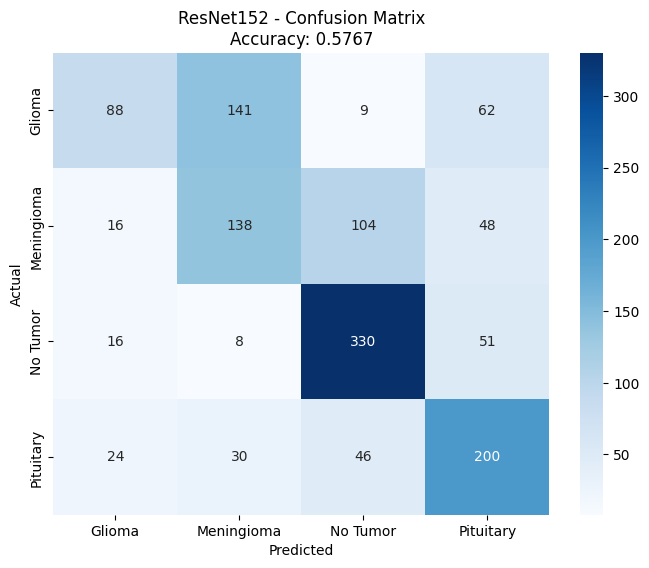


Classification Report for ResNet152:
              precision    recall  f1-score   support

      Glioma       0.61      0.29      0.40       300
  Meningioma       0.44      0.45      0.44       306
    No Tumor       0.67      0.81      0.74       405
   Pituitary       0.55      0.67      0.61       300

    accuracy                           0.58      1311
   macro avg       0.57      0.56      0.55      1311
weighted avg       0.58      0.58      0.56      1311


Evaluating VGG19
11/11 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step


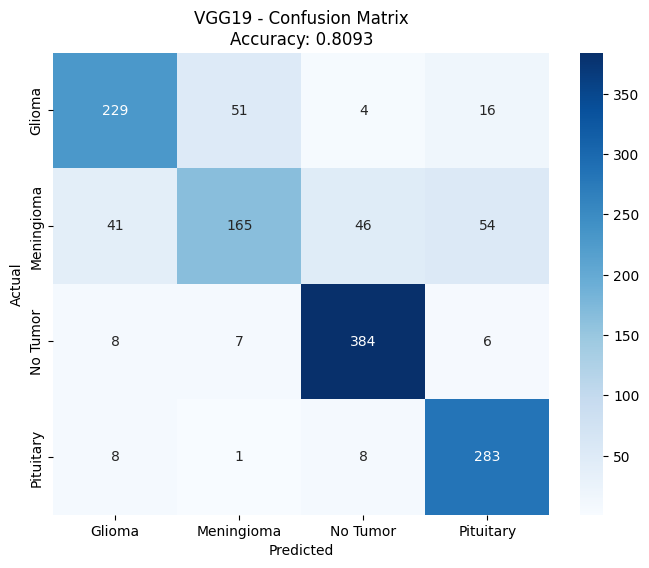


Classification Report for VGG19:
              precision    recall  f1-score   support

      Glioma       0.80      0.76      0.78       300
  Meningioma       0.74      0.54      0.62       306
    No Tumor       0.87      0.95      0.91       405
   Pituitary       0.79      0.94      0.86       300

    accuracy                           0.81      1311
   macro avg       0.80      0.80      0.79      1311
weighted avg       0.80      0.81      0.80      1311


Evaluating DenseNet169
11/11 ━━━━━━━━━━━━━━━━━━━━ 44s 3s/step


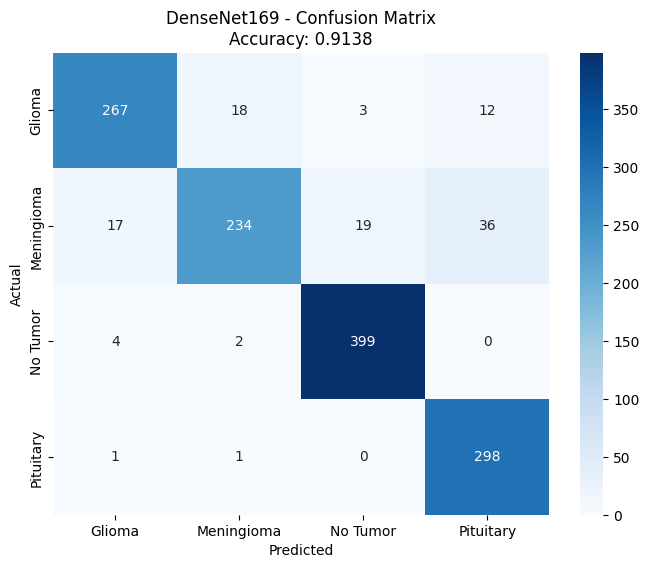


Classification Report for DenseNet169:
              precision    recall  f1-score   support

      Glioma       0.92      0.89      0.91       300
  Meningioma       0.92      0.76      0.83       306
    No Tumor       0.95      0.99      0.97       405
   Pituitary       0.86      0.99      0.92       300

    accuracy                           0.91      1311
   macro avg       0.91      0.91      0.91      1311
weighted avg       0.92      0.91      0.91      1311


Evaluating MobileNetV3
11/11 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step


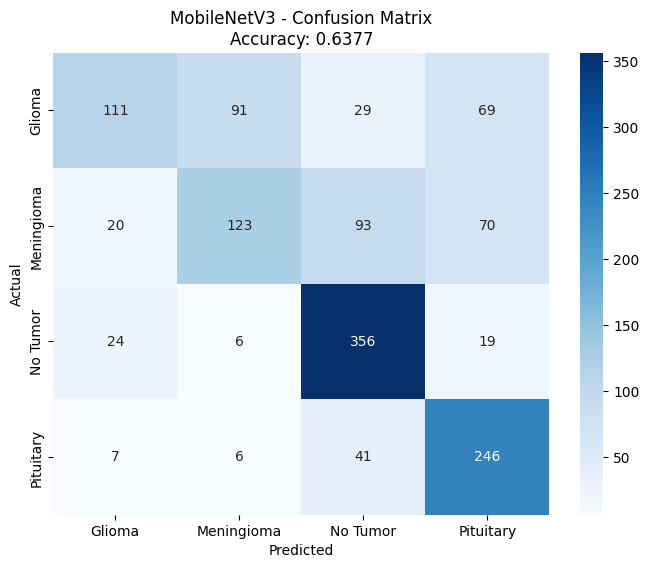


Classification Report for MobileNetV3:
              precision    recall  f1-score   support

      Glioma       0.69      0.37      0.48       300
  Meningioma       0.54      0.40      0.46       306
    No Tumor       0.69      0.88      0.77       405
   Pituitary       0.61      0.82      0.70       300

    accuracy                           0.64      1311
   macro avg       0.63      0.62      0.60      1311
weighted avg       0.64      0.64      0.62      1311



In [ ]:

def evaluate_model(model, test_gen, model_name):
    print(f"\n{'='*50}")
    print(f"Evaluating {model_name}")
    print(f"{'='*50}")

    # Get predictions
    y_pred = model.predict(test_gen)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = test_gen.classes

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred_classes)
    cm = confusion_matrix(y_true, y_pred_classes)
    report = classification_report(y_true, y_pred_classes,
                                 target_names=class_labels, output_dict=True)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_labels,
                yticklabels=class_labels)
    plt.title(f'{model_name} - Confusion Matrix\nAccuracy: {accuracy:.4f}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Print classification report
    print(f"\nClassification Report for {model_name}:")
    print(classification_report(y_true, y_pred_classes, target_names=class_labels))

    return accuracy, cm, report

# Evaluate all models
results = {}
for name, model in models_dict.items():
    accuracy, cm, report = evaluate_model(model, test_generator, name)
    results[name] = {
        'accuracy': accuracy,
        'confusion_matrix': cm,
        'classification_report': report
    }

### Performance comparison table

Performance Comparison:
         Model  Test Accuracy  Training Time (s)
2  DenseNet169         0.9138          4090.2532
1        VGG19         0.8093          3557.7079
3  MobileNetV3         0.6377          3765.6979
0    ResNet152         0.5767          2702.2278


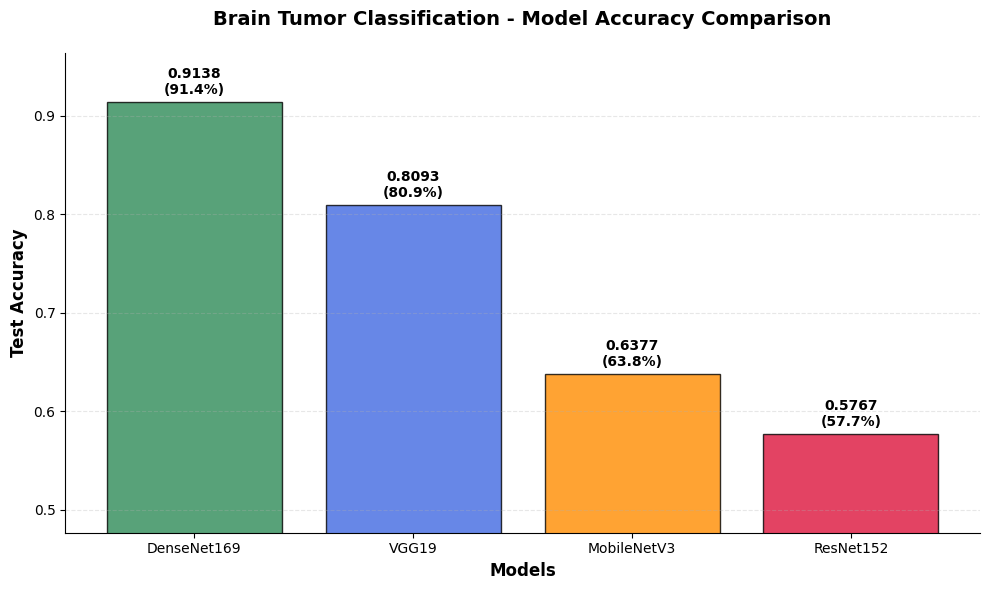


Best Model: DenseNet169 with 0.9138 accuracy


In [ ]:

performance_table = pd.DataFrame({
    'Model': list(results.keys()),
    'Test Accuracy': [results[model]['accuracy'] for model in results.keys()],
    'Training Time (s)': [training_times[model] for model in results.keys()]
})

# Sort by accuracy for better visualization
performance_table = performance_table.sort_values('Test Accuracy', ascending=False)

print("Performance Comparison:")
print(performance_table.round(4))

# Plot accuracy comparison - IMPROVED VERSION
plt.figure(figsize=(10, 6))
models = performance_table['Model']
accuracies = performance_table['Test Accuracy']

# Create bars
colors = ['#2E8B57', '#4169E1', '#FF8C00', '#DC143C']  # Better colors
bars = plt.bar(models, accuracies, color=colors, alpha=0.8, edgecolor='black', linewidth=1)

plt.title('Brain Tumor Classification - Model Accuracy Comparison', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Models', fontsize=12, fontweight='bold')
plt.ylabel('Test Accuracy', fontsize=12, fontweight='bold')

# Set dynamic y-axis limits
y_min = max(0, min(accuracies) - 0.1)
y_max = min(1.0, max(accuracies) + 0.05)
plt.ylim(y_min, y_max)

# Add value labels on bars
for bar, accuracy in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
             f'{accuracy:.4f}\n({accuracy*100:.1f}%)',
             ha='center', va='bottom', fontweight='bold', fontsize=10)

# Customize grid and appearance
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

# Print summary
print(f"\nBest Model: {performance_table.iloc[0]['Model']} "
      f"with {performance_table.iloc[0]['Test Accuracy']:.4f} accuracy")

### Detailed metrics table

In [ ]:

def create_detailed_metrics_table(results):
    metrics_data = []

    for model_name, result in results.items():
        report = result['classification_report']

        for i, class_name in enumerate(class_labels):
            metrics_data.append({
                'Architecture': model_name,
                'Class': class_name,
                'Precision': report[class_name]['precision'],
                'Recall': report[class_name]['recall'],
                'F1-Score': report[class_name]['f1-score']
            })

    return pd.DataFrame(metrics_data)

detailed_metrics = create_detailed_metrics_table(results)
print("Detailed Performance Metrics:")
print(detailed_metrics.round(4))

Detailed Performance Metrics:
   Architecture       Class  Precision  Recall  F1-Score
0     ResNet152      Glioma     0.6111  0.2933    0.3964
1     ResNet152  Meningioma     0.4353  0.4510    0.4430
2     ResNet152    No Tumor     0.6748  0.8148    0.7383
3     ResNet152   Pituitary     0.5540  0.6667    0.6051
4         VGG19      Glioma     0.8007  0.7633    0.7816
5         VGG19  Meningioma     0.7366  0.5392    0.6226
6         VGG19    No Tumor     0.8688  0.9481    0.9067
7         VGG19   Pituitary     0.7883  0.9433    0.8589
8   DenseNet169      Glioma     0.9239  0.8900    0.9066
9   DenseNet169  Meningioma     0.9176  0.7647    0.8342
10  DenseNet169    No Tumor     0.9477  0.9852    0.9661
11  DenseNet169   Pituitary     0.8613  0.9933    0.9226
12  MobileNetV3      Glioma     0.6852  0.3700    0.4805
13  MobileNetV3  Meningioma     0.5442  0.4020    0.4624
14  MobileNetV3    No Tumor     0.6859  0.8790    0.7706
15  MobileNetV3   Pituitary     0.6089  0.8200    0.6989


### Training timeline visualization

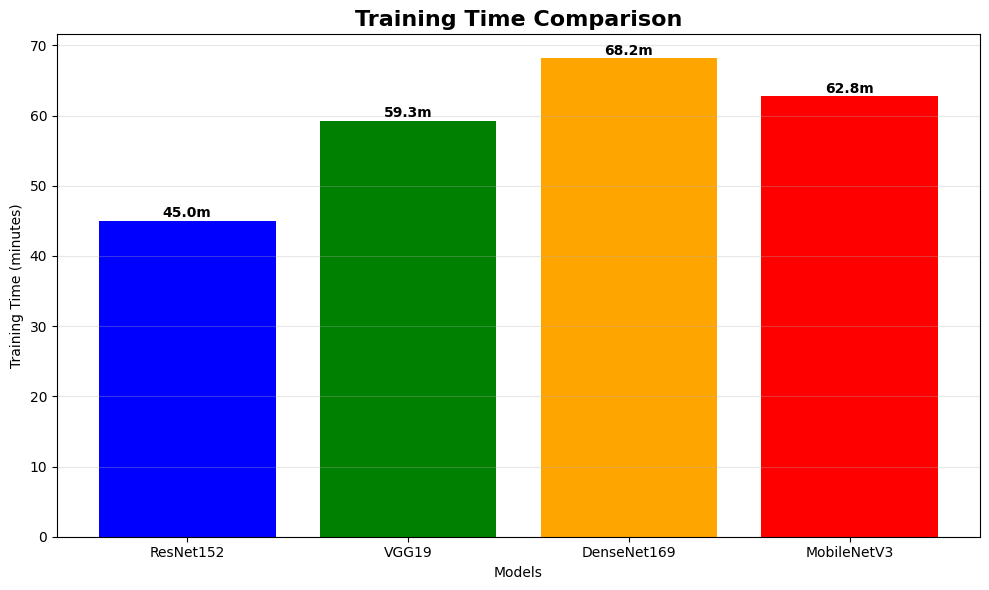

Training Times:
ResNet152: 45 minutes 2 seconds
VGG19: 59 minutes 17 seconds
DenseNet169: 68 minutes 10 seconds
MobileNetV3: 62 minutes 45 seconds


In [ ]:

plt.figure(figsize=(10, 6))
models = list(training_times.keys())
times = [time/60 for time in training_times.values()]  # Convert to minutes

bars = plt.bar(models, times, color=['blue', 'green', 'orange', 'red'])
plt.title('Training Time Comparison', fontsize=16, fontweight='bold')
plt.xlabel('Models')
plt.ylabel('Training Time (minutes)')

# Add value labels on bars
for bar, time_val in zip(bars, times):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
             f'{time_val:.1f}m', ha='center', va='bottom', fontweight='bold')

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print("Training Times:")
for model, time_val in training_times.items():
    minutes = time_val // 60
    seconds = time_val % 60
    print(f"{model}: {int(minutes)} minutes {int(seconds)} seconds")

### Fine-tuning step (as mentioned in the paper)

Best model for fine-tuning: DenseNet169

Fine-tuning DenseNet169...
Epoch 1/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 690s 10s/step - accuracy: 0.7695 - loss: 1.4344 - val_accuracy: 0.6477 - val_loss: 1.3025
Epoch 2/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 95s 3s/step - accuracy: 0.9566 - loss: 0.1190 - val_accuracy: 0.6293 - val_loss: 1.6881
Epoch 3/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 94s 3s/step - accuracy: 0.9730 - loss: 0.0718 - val_accuracy: 0.7397 - val_loss: 1.2108
Epoch 4/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 94s 3s/step - accuracy: 0.9861 - loss: 0.0399 - val_accuracy: 0.7721 - val_loss: 1.1202
Epoch 5/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 93s 3s/step - accuracy: 0.9884 - loss: 0.0301 - val_accuracy: 0.8799 - val_loss: 0.6130
Epoch 6/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 94s 3s/step - accuracy: 0.9923 - loss: 0.0201 - val_accuracy: 0.8992 - val_loss: 0.5014
Epoch 7/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 95s 3s/step - accuracy: 0.9941 - loss: 0.0200 - val_accuracy: 0.8878 - val_loss: 0.6235
Epoch 8/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 94s 3s/ste

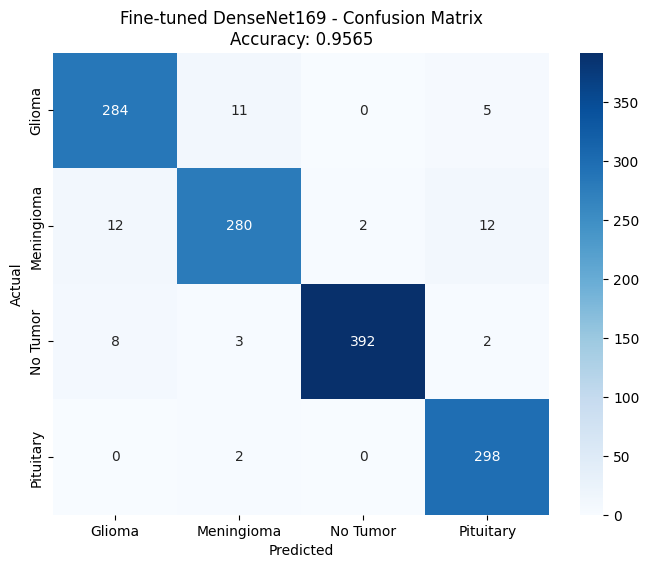


Classification Report for Fine-tuned DenseNet169:
              precision    recall  f1-score   support

      Glioma       0.93      0.95      0.94       300
  Meningioma       0.95      0.92      0.93       306
    No Tumor       0.99      0.97      0.98       405
   Pituitary       0.94      0.99      0.97       300

    accuracy                           0.96      1311
   macro avg       0.95      0.96      0.95      1311
weighted avg       0.96      0.96      0.96      1311



In [ ]:

def fine_tune_model(model, model_name):
    print(f"\nFine-tuning {model_name}...")

    # Unfreeze the base model
    model.layers[0].trainable = True

    # Recompile with lower learning rate
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE/10),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Fine-tune for fewer epochs
    fine_tune_epochs = 10

    history_fine = model.fit(
        train_generator,
        epochs=fine_tune_epochs,
        validation_data=val_generator,
        verbose=1
    )

    return history_fine

# Fine-tune the best performing model
best_model_name = max(results, key=lambda x: results[x]['accuracy'])
print(f"Best model for fine-tuning: {best_model_name}")

# Fine-tune the best model
fine_tune_history = fine_tune_model(models_dict[best_model_name], best_model_name)

# Evaluate after fine-tuning
final_accuracy, final_cm, final_report = evaluate_model(
    models_dict[best_model_name], test_generator, f"Fine-tuned {best_model_name}"
)

### Final results summary

In [ ]:

print("\n" + "="*60)
print("FINAL RESULTS SUMMARY")
print("="*60)

for model_name in results.keys():
    acc = results[model_name]['accuracy']
    print(f"{model_name}: {acc:.4f} ({acc*100:.2f}%)")

print(f"\nBest Model: {best_model_name}")
print(f"Best Accuracy: {results[best_model_name]['accuracy']:.4f} ({results[best_model_name]['accuracy']*100:.2f}%)")

# Compare with paper results
paper_results = {
    'ResNet152': 0.985,
    'VGG19': 0.960,
    'DenseNet169': 0.9675,
    'MobileNetV3': 0.9975
}

print("\nComparison with Paper Results:")
print("-" * 40)
for model in paper_results.keys():
    paper_acc = paper_results[model]
    our_acc = results[model]['accuracy'] if model in results else 0
    diff = our_acc - paper_acc
    print(f"{model}: Paper={paper_acc:.4f}, Our={our_acc:.4f}, Difference={diff:+.4f}")

# Save models locally
for name, model in models_dict.items():
    model.save(f'{name}_brain_tumor_model.h5')
    print(f"Saved {name}_brain_tumor_model.h5")

print("\nImplementation completed successfully!")


FINAL RESULTS SUMMARY
ResNet152: 0.5767 (57.67%)
VGG19: 0.8093 (80.93%)
DenseNet169: 0.9138 (91.38%)
MobileNetV3: 0.6377 (63.77%)

Best Model: DenseNet169
Best Accuracy: 0.9138 (91.38%)

Comparison with Paper Results:
----------------------------------------
ResNet152: Paper=0.9850, Our=0.5767, Difference=-0.4083
VGG19: Paper=0.9600, Our=0.8093, Difference=-0.1507
DenseNet169: Paper=0.9675, Our=0.9138, Difference=-0.0537
MobileNetV3: Paper=0.9975, Our=0.6377, Difference=-0.3598


Saved ResNet152_brain_tumor_model.h5


Saved VGG19_brain_tumor_model.h5


Saved DenseNet169_brain_tumor_model.h5
Saved MobileNetV3_brain_tumor_model.h5

Implementation completed successfully!
